In [21]:
import pickle
import numpy as np
import netCDF4 as nc
import epicc_config as cfg
import pandas as pd
import matplotlib.pyplot as plt
import wrf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from glob import glob

In [27]:
def map_bounds(reg):

    if reg=='EPICC':
        mbounds = None
    else:
        mbounds = wrf.GeoBounds(wrf.CoordPair(lat=cfg.reg_coords[reg][0], lon=cfg.reg_coords[reg][1]),
                               wrf.CoordPair(lat=cfg.reg_coords[reg][2], lon=cfg.reg_coords[reg][3]))
    return mbounds

def customize_plots():

    mpl.style.use('seaborn-paper')

    mpl.rcParams['font.size']=16
    mpl.rcParams['font.weight']='demibold'

    mpl.rcParams['axes.spines.left']=True
    mpl.rcParams['axes.spines.bottom']=True
    mpl.rcParams['axes.spines.right']=False
    mpl.rcParams['axes.spines.top']=False
    #mpl.rcParams['font.family'] = 'sans-serif'
    #mpl.rcParams['font.sans-serif'] = 'Tahoma'

def adjust_spines2(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([])

In [23]:
wrf_runs = cfg.wrf_runs
lsmooth = 50000 #Smoothing filter length in meters
dx = 2000 #Resolution of imput data
lsmooth_ngrid = np.ceil(lsmooth/dx)
pr_threshold_mmhr = 2.5 #Precipitation threshold in mm/h
freq = '01H'

mmh_factor = {'10MIN': 6.,
              '01H'  : 1.,
              'DAY'  : 1/24.}

freq_dt = {'10MIN': 600,
          '01H'  : 3600,
          'DAY'  : 86400.}

pr_threshold = pr_threshold_mmhr/mmh_factor[freq]
dt = freq_dt[freq] #Step between model outputs in seconds
wrun = wrf_runs[0]
reg = 'EPICC'

In [24]:
#Loading geo info from WRF
geofile_ref = nc.Dataset(f'{cfg.geofile_ref}')
xbounds = wrf.cartopy_xlim(wrfin=geofile_ref)
ybounds = wrf.cartopy_ylim(wrfin=geofile_ref)
geo_proj = wrf.get_cartopy(wrfin=geofile_ref)


hgt = wrf.getvar(geofile_ref, "ter")
lats, lons = wrf.latlon_coords(hgt)

mbounds = map_bounds(reg)



In [54]:
filesin = sorted(glob(f"{cfg.path_in}/{wrun}/Storm_properties_20??-09_no???_thres-{pr_threshold_mmhr}mmhr_smooth-{lsmooth/1000}km.pkl"))
datalist = []
for nf,fin in enumerate(filesin):
    
    storm_id = nf+1
    storm_idy = fin.split("_no")[-1][0:3]
    this_storm = pd.read_pickle(filesin[nf])
    
    storm_times = pd.date_range(this_storm['storm_start'].replace("_"," "),this_storm['storm_end'].replace("_"," "),freq='1H')
    
    for nstep in range(int(this_storm['storm_duration'])):
        datalist.append([storm_id,
                         storm_idy,
                         nstep,
                         storm_times[nstep],
                         this_storm['storm_size'][nstep],
                         this_storm['storm_prvol'][nstep],
                         this_storm['storm_prmax'][nstep],
                         this_storm['storm_prmean'][nstep],
                         this_storm['storm_speed'][nstep],
                         int(this_storm['storm_duration']),
                         this_storm['storm_mass_center'][nstep,1],
                         this_storm['storm_mass_center'][nstep,0],
                         lons.interp(south_north=this_storm['storm_mass_center'][nstep,0],west_east=this_storm['storm_mass_center'][nstep,1]).values,
                         lats.interp(south_north=this_storm['storm_mass_center'][nstep,0],west_east=this_storm['storm_mass_center'][nstep,1]).values,
                         this_storm['storm_prtile_all'][75],
#                          this_storm['storm_prtile_all'][80],
#                          this_storm['storm_prtile_all'][85],
#                          this_storm['storm_prtile_all'][90],
#                          this_storm['storm_prtile_all'][95],
#                          this_storm['storm_prtile_all'][99],
#                          this_storm['storm_hitend'],
#                          this_storm['storm_hitborder'][nstep]
                                              ])
storms = pd.DataFrame(datalist, columns=['storm_id', 'storm_id_year', 'nstep','datetime',
                                         'size','prvol','prmax','prmean','speed','duration','x','y','lon','lat','p75'])#,'p80','p85','p90','p95','p99',
                                         #'hit_end','hit_border'])
    

        
    

In [20]:
storms = storms.loc[(storms.lon>cfg.reg_coords[reg][1]) & (storms.lon<cfg.reg_coords[reg][3])]
storms = storms.loc[(storms.lat>cfg.reg_coords[reg][0]) & (storms.lat<cfg.reg_coords[reg][2])]

KeyError: 'EPICC'

/home/dargueso/anaconda3/envs/e3_epicc_env/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/dargueso/anaconda3/envs/e3_epicc_env/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/dargueso/anaconda3/envs/e3_epicc_env/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


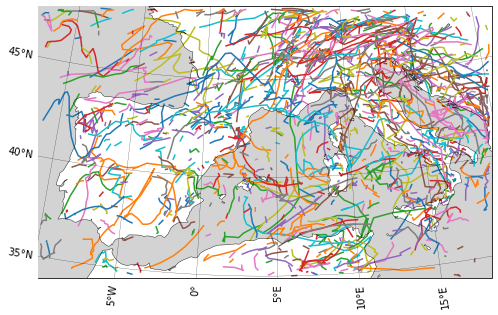

In [55]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1,1,1,projection=geo_proj)
oce10m = cfeature.NaturalEarthFeature('physical', 'ocean', '50m')
lakes10m = cfeature.NaturalEarthFeature('physical', 'lakes', '50m')
ax.add_feature(oce10m , zorder=100,facecolor='lightgray')#facecolor=[24/255,  116/255,  205/255])
ax.add_feature(lakes10m, zorder=100,linewidth=0.5,edgecolor='k',facecolor='lightgray')
               #facecolor=[24/255,  116/255,  205/255])
ax.coastlines(linewidth=0.4,zorder=103,resolution='50m')
gl=ax.gridlines(crs=ccrs.PlateCarree(), xlocs=range(-25,35,5), ylocs=range(20,60,5),x_inline=False, y_inline=False,
                draw_labels=True, zorder=103,linewidth=0.2, color='k', alpha=1, linestyle='-')

for nstorm in storms['storm_id'].unique():
    plt.plot(storms.loc[storms['storm_id'] == nstorm].lon, 
             storms.loc[storms['storm_id'] == nstorm].lat,
             transform=ccrs.PlateCarree(),zorder=101)
gl.top_labels = False
gl.right_labels = False
ax.set_xlim(xbounds)
ax.set_ylim(ybounds)
# if reg !='EPICC':
#     ax.set_xlim(wrf.cartopy_xlim(hgt,geobounds=mbounds))
#     ax.set_ylim(wrf.cartopy_ylim(hgt,geobounds=mbounds))
fig.subplots_adjust(left=0.05,right=0.95,top=0.95,bottom=0.18,wspace=0.1,hspace=0.5)
plt.show()

In [57]:
filesin = sorted(glob(f"{cfg.path_in}/{wrun}/Storm_properties_20??-??_no???_thres-{pr_threshold_mmhr}mmhr_smooth-{lsmooth/1000}km.pkl"))
datalist = []
for nf,fin in enumerate(filesin):
    
    storm_id = nf+1
    storm_idy = fin.split("_no")[-1][0:3]
    this_storm = pd.read_pickle(filesin[nf])
    storm_times = pd.date_range(this_storm['storm_start'].replace("_"," "),this_storm['storm_end'].replace("_"," "),freq='1H')
    
    datalist.append([storm_id,
                     storm_idy,
                     this_storm['storm_size'].max(),
                     this_storm['storm_prvol'].sum(),
                     np.nanmax(this_storm['storm_speed']),
                     this_storm['storm_prmax'].max(),
                     this_storm['storm_prtile_all'][99],
                     int(this_storm['storm_duration']),
                    ])
    
    
    
    
storms_summary = pd.DataFrame(datalist, columns=['storm_id', 'storm_id_year','max_size','tot_vol','max_speed','prmax','p99','duration'])    



/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: RuntimeWarning: All-NaN slice encountered
  np.nanmax(this_storm['storm_speed']),
/tmp/ipykernel_3962/1789496816.py:14: Ru

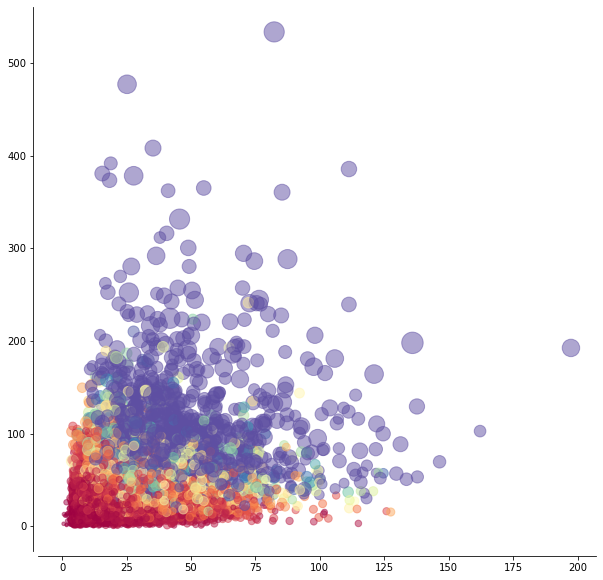

In [61]:
fig, ax = plt.subplots(1, 1, sharex=True,gridspec_kw={'height_ratios': [1]},figsize=(10, 10))
fig.subplots_adjust(hspace=0.1)

adjust_spines2(ax, ['left','bottom'])
               
               
ax.scatter(storms_summary.prmax,storms_summary.max_speed,
           s=(storms_summary.max_size)**0.5,
           c=storms_summary.tot_vol,cmap='Spectral',
           vmin=0, vmax=100000,
           alpha=0.5)


In [36]:
storms_summary.max_speed

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
476   NaN
477   NaN
478   NaN
479   NaN
480   NaN
Name: max_speed, Length: 481, dtype: float64